## Homework: Problem 1

a) Implement a PD based trajectory-tracking controller for the robot.

b) Use the controller to track the end-effector trajectories defined by the function 'trajectory(t)' which is implemented in this file. 

c) Provide plots comparing the desired and actual values to show the tracking performance of the controller. Show plots for the joint angles and the end-effector co-ordinates.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install pybullet --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 1.2 MB/s 


In [3]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

In [4]:
#################################################################
# Forward and Inverse kinematics modules for the serial-2R robot
#################################################################

def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(theta1) + l2*math.cos(theta1 + theta2)
    y = l1*math.sin(theta1) + l2*math.sin(theta1 + theta2)
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        # print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [5]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = p.connect(p.DIRECT) # or p.GUI


# Load the URDF of the plane that forms the ground
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = p.loadURDF("plane.urdf")


# Load the URDF of the robot
robot = p.loadURDF("/content/drive/MyDrive/Colab Notebooks/planar_2R_robot.urdf.urdf")

In [6]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
p.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
p.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [7]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
p.setJointMotorControl2(robot, 1, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(robot, 2, p.VELOCITY_CONTROL, force=0)

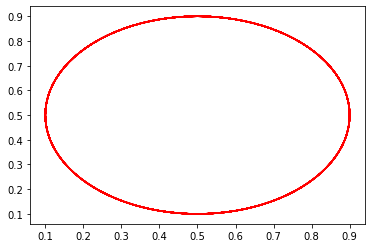

In [8]:
#######################################
# Define functions for the trajectories
#######################################


def trajectory(t):
    '''
    A function to specify the trajectory
    Args:
    t: time
    Returns:
    x: X coordinate of the end-effector
    y: Y coordinate of the end-effector
    '''
    
    r = 0.4
    omega = 2*np.pi*2
    
    # Centre of trajectory
    [x0, y0] = [0.5, 0.5]
    
    x = x0 + r*np.cos(omega*t)
    y = y0 + r*np.sin(omega*t)
    
    return x, y

# Plot the trajectory
x_plt = []; y_plt = [];
for t in np.arange(0, 5, 0.005):
    x, y = trajectory(t)
    x_plt.append(x)
    y_plt.append(y)
    
        


plt.plot(x_plt, y_plt, 'red')
 
plt.show()


In [12]:
##########################################
# Control loop to follow the trajectory
##########################################

# WRITE YOUR CODE HERE #

Kp = 27
Kd = 3.0

l1 = 1.0
l2 = 0.8

plot_data_q1 = []
plot_data_q2 = []

plot_data_q1_d = []
plot_data_q2_d = []

plot_data_x = []
plot_data_y = []

plot_data_xd = []
plot_data_yd = []

for t in np.arange(0, 5, 0.005):
  x_d, y_d = trajectory(t)
  plot_data_xd.append(x_d)
  plot_data_yd.append(y_d)

  valid, [q1_d, q2_d] = inverse_kinematics(x_d, y_d, l1, l2)
  plot_data_q1_d.append(q1_d)
  plot_data_q2_d.append(q2_d)

  for dt in range(100):
    Q1 = p.getJointState(robot, 1)
    q1, dq1 = Q1[0], Q1[1]
    Q2 = p.getJointState(robot, 2)
    q2, dq2 = Q2[0], Q2[1]

    tau_fb_1 = Kp*(q1_d - q1) + Kd*(-dq1)
    tau_fb_2 = Kp*(q2_d - q2) + Kd*(-dq2)

    p.setJointMotorControlArray(robot, [1,2], controlMode=p.TORQUE_CONTROL, forces=[tau_fb_1, tau_fb_2])
    p.stepSimulation()

  Q1 = p.getJointState(robot, 1)
  q1, dq1 = Q1[0], Q1[1]
  Q2 = p.getJointState(robot, 2)
  q2, dq2 = Q2[0], Q2[1]

  plot_data_q1.append(q1)
  plot_data_q2.append(q2)

  x, y = forward_kinematics(q1, q2, l1, l2)

  plot_data_x.append(x)
  plot_data_y.append(y)


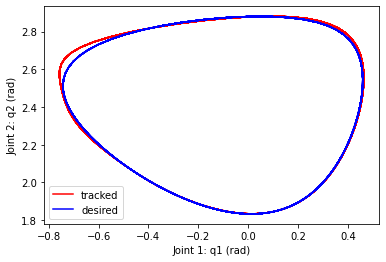

In [13]:
##########################################
# Plot the data in joint-space
##########################################

# WRITE YOUR CODE HERE #
plt.plot(plot_data_q1, plot_data_q2, 'red', label='tracked')
plt.plot(plot_data_q1_d, plot_data_q2_d, 'blue', label='desired')
plt.legend()
plt.xlabel('Joint 1: q1 (rad)')
plt.ylabel('Joint 2: q2 (rad)')
plt.show()

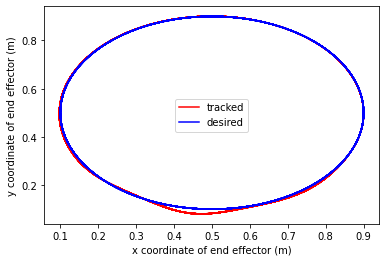

In [14]:
##########################################
# Plot the data in task-space
##########################################

# WRITE YOUR CODE HERE #
plt.plot(plot_data_x, plot_data_y, 'red', label='tracked')
plt.plot(plot_data_xd, plot_data_yd, 'blue', label='desired')
plt.legend()
plt.xlabel('x coordinate of end effector (m)')
plt.ylabel('y coordinate of end effector (m)')
plt.show()
